# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from scipy import integrate

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':100000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "test_tprime/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# definition of Deep-TICA cvs 
deep: PYTORCH_MODEL FILE=../unbias/deeptica/model.ptc ARG=p.x,p.y

# Bias 
opes: OPES_METAD ARG=deep.node-0,deep.node-1 TEMP=0.5 PACE=500 FILE=KERNELS BARRIER=7.5 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

#print logweights
PRINT ARG=opes.bias FILE=Tprime STRIDE=1

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=deep.node-0,deep.node-1,p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data test_tprime/


# Tprime Analysis 
```py
def tprime_evaluation(t=None,logweights=None):

    # rescale time with log-weights if given
    if logweights is not None:
        # compute time increment in simulation time t
        dt = np.round(t[1]-t[0],3)
        # sanitize logweights
        logweights = torch.Tensor(logweights)
        logweights -= torch.max(logweights)
        lognorm = torch.logsumexp(logweights,0)
        logweights /= lognorm
        # compute instantaneus time increment in rescaled time t'
        d_tprime = torch.exp(logweights)*dt
        # calculate cumulative time t'
        tprime = torch.cumsum(d_tprime,0)
    else:
        tprime = t

    return tprime
```

Completed: rm Tprime


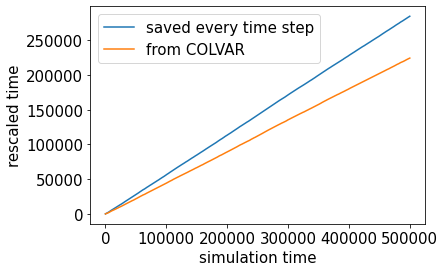

In [4]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p.').columns.values

# load data from file of dtprime estimated at each step
try:
    time_data = load_dataframe(folder+"Tprime")
    # tprime estimation using dtprime evaluated at each time step
    tprime = (tprime_evaluation(t=time_data["time"],logweights = time_data["opes.bias"]/sim_parameters["temp"] )).numpy()
    # stride di 200 
    stride = 200
except:
    print("load from tprime.txt")
    tprime = np.loadtxt(folder+"tprime.txt")
    stride = 1

X = data[descriptors_names].to_numpy()
# unbias time
t = data["time"].to_numpy()
tprime = tprime[::stride]
# save result on file (to not repeat the simulation)
np.savetxt(folder+"tprime.txt",tprime)


# remove Tprime file, which is very large
execute("rm Tprime",folder=folder)

# plotting
plt.plot(t,tprime,label="saved every time step")

# tprime estimation using dtprime evaluated every 200 time steps (from COLVAR)
tprime_colvar = tprime_evaluation(t=data["time"], logweights = data["opes.bias"]/sim_parameters["temp"] ).numpy()
# plotting
plt.plot(t,tprime_colvar,label="from COLVAR")
plt.xlabel("simulation time")
plt.ylabel("rescaled time")
plt.legend()

# Training with the new tprime (estimated at each time step)

In [5]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [6]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters,tprime=tprime)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Time-lagged pairs:	 995201
Training data:		 696640
Validation data:	 298561
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.373      -1.373      0.924  0.445  
100   -1.486      -1.490      0.939  0.529  
150   -1.470      -1.475      0.939  0.532  
INFO: Early stopping
172   -1.471      -1.475      0.939  0.532  
timescales:  [15.910986   1.5829365]
eigenvalues:  [0.93908465 0.53166735]
gap:  0.4074173


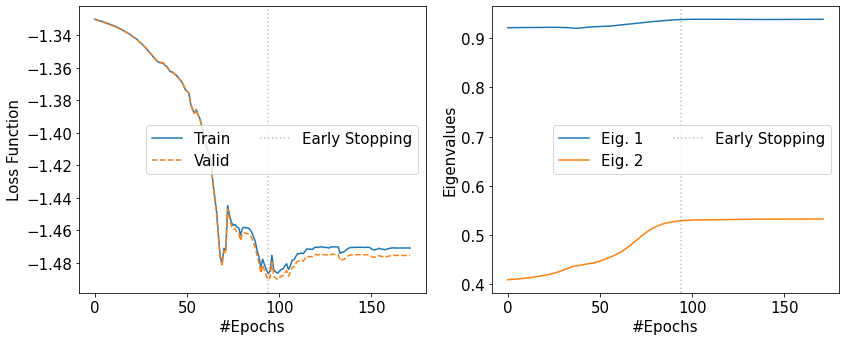

In [7]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [8]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

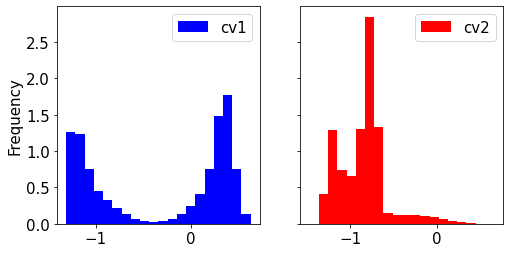

In [9]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

### FES estimate from new cvs  

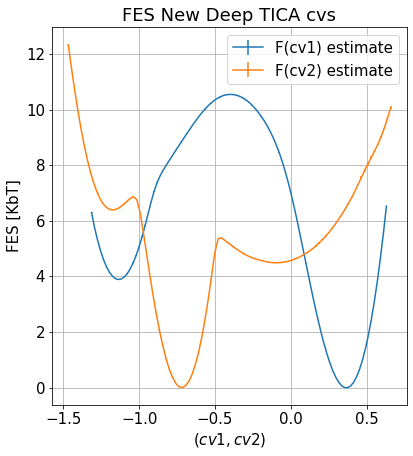

In [10]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New Deep TICA cvs")

plt.show()

### Isolines      

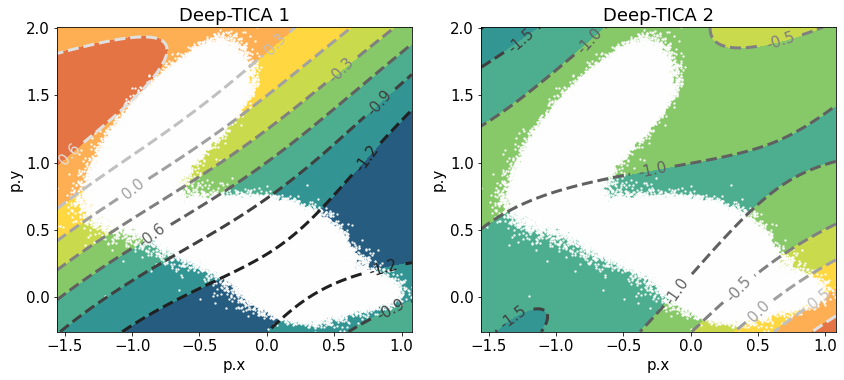

In [11]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

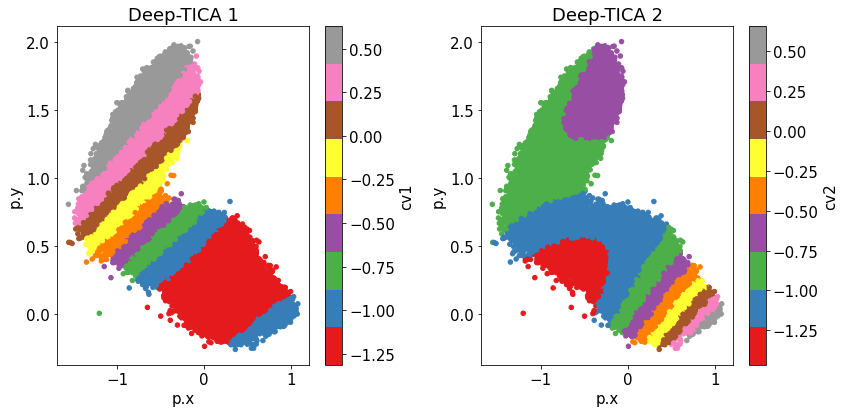

In [14]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  

In [13]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

-0.015576820595228228

# Training with the usual tprime (estimated at every 200 time step)

## DeepTICA Analysis and Export

In [15]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters,tprime=tprime_colvar)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Time-lagged pairs:	 987629
Training data:		 691340
Validation data:	 296289
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.275      -1.269      0.902  0.369  
100   -1.355      -1.351      0.921  0.409  
150   -1.339      -1.335      0.927  0.411  
INFO: Early stopping
156   -1.339      -1.336      0.927  0.411  
timescales:  [13.279838  1.126187]
eigenvalues:  [0.92746323 0.41149762]
gap:  0.5159656


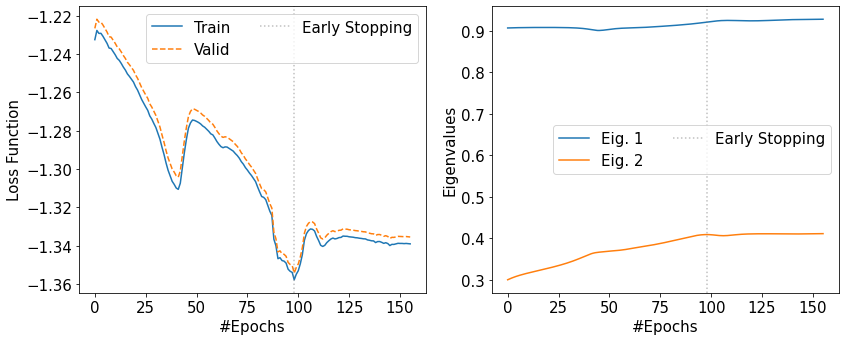

In [16]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [17]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

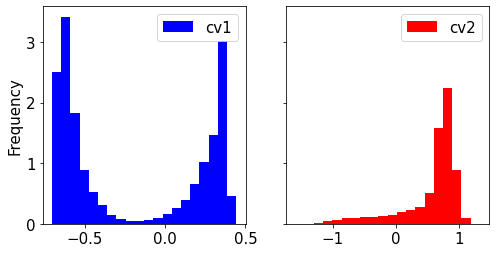

In [18]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

### FES estimate from new cvs  

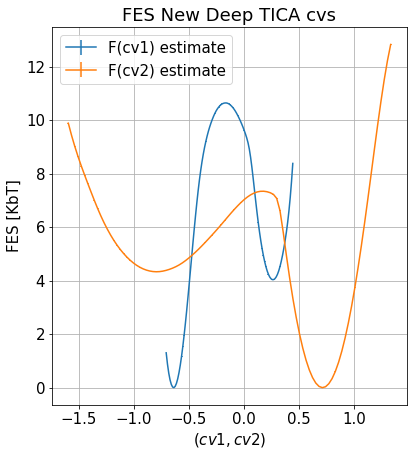

In [19]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New Deep TICA cvs")

plt.show()

### Isolines      

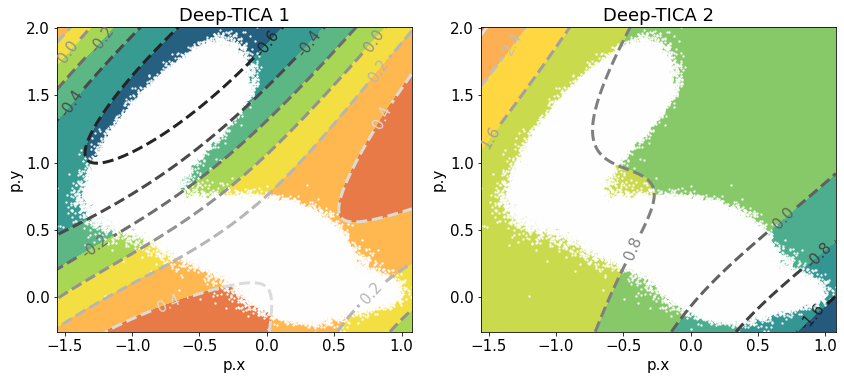

In [20]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

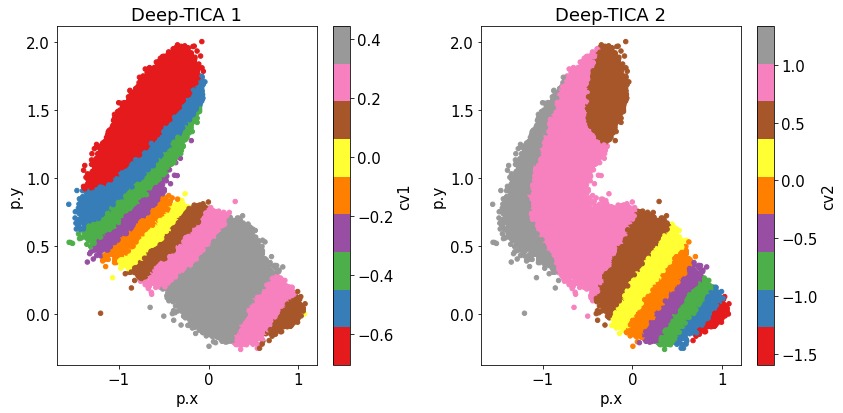

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  

In [22]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

-0.0272101786975228